In [1]:
#| default_exp core

In [2]:
#| export
import concurrent
import io
import logging
import re
import re2

import cairosvg
import kagglehub
import torch
from lxml import etree
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers.models.gemma3 import Gemma3ForConditionalGeneration, Gemma3Processor, Gemma3ForCausalLM

svg_constraints = kagglehub.package_import('metric/svg-constraints')

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Model:
    def __init__(self):
         # Quantization Configuration
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )

        self.model_path = kagglehub.model_download("google/gemma-3/transformers/gemma-3-12b-it")
        self.processor = Gemma3Processor.from_pretrained(self.model_path, use_fast=True)
        self.model = Gemma3ForConditionalGeneration.from_pretrained(self.model_path, 
                                                                    quantization_config=quantization_config,
                                                                    torch_dtype=torch.bfloat16, 
                                                                    device_map="auto",)
        

        self.prompt_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints and guidelines.

<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
* **Output Format:** Always use viewBox="0 0 256 256" with width="256" height="256"
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="128" cy="128" r="80" fill="red"/>
  <rect x="88" y="88" width="80" height="80" fill="blue"/>
</svg>
```
</example>

Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.

<description>"{}"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
"""
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.constraints = svg_constraints.SVGConstraints()
        self.timeout_seconds = 200 #90

    # You could try increasing `max_new_tokens`
    def predict(self, description: str, max_new_tokens=512) -> str:
        def generate_svg():
            try:
                prompt = self.prompt_template.format(description)
                # inputs = self.tokenizer(text=prompt, return_tensors="pt" , add_bos=True).to(DEVICE)
                inputs = self.processor(text=prompt, return_tensors="pt").to(DEVICE)

                with torch.no_grad():
                    output = self.model.generate(
                        **inputs,
                        max_new_tokens=max_new_tokens,
                        do_sample=True,
                        #temperature=0.8,
                        #top_p=0.95,  # Add nucleus sampling
                    )

                output_decoded = self.processor.decode(output[0], 
                                                       skip_special_tokens=True, 
                                                       clean_up_tokenization_spaces=False)
                logging.debug('Output decoded from model: %s', output_decoded)

                matches = re.findall(r"<svg.*?</svg>", output_decoded, re.DOTALL | re.IGNORECASE)
                if matches:
                    svg = matches[-1]
                else:
                    return self.default_svg

                logging.debug('Unprocessed SVG: %s', svg)
                svg = self.enforce_constraints(svg)
                logging.debug('Processed SVG: %s', svg)
                # Ensure the generated code can be converted by cairosvg
                cairosvg.svg2png(bytestring=svg.encode('utf-8'))
                return svg
            except Exception as e:
                logging.error('Exception during SVG generation: %s', e)
                return self.default_svg

        # Execute SVG generation in a new thread to enforce time constraints
        with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
            future = executor.submit(generate_svg)
            try:
                return future.result(timeout=self.timeout_seconds)
            except concurrent.futures.TimeoutError:
                logging.warning("Prediction timed out after %s seconds.", self.timeout_seconds)
                return self.default_svg
            except Exception as e:
                logging.error(f"An unexpected error occurred: {e}")
                return self.default_svg

    def enforce_constraints(self, svg_string: str) -> str:
        """Enforces constraints on an SVG string, removing disallowed elements
        and attributes.

        Parameters
        ----------
        svg_string : str
            The SVG string to process.

        Returns
        -------
        str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
        """
        logging.info('Sanitizing SVG...')

        try:
            parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            return self.default_svg
    
        elements_to_remove = []
        for element in root.iter():
            tag_name = etree.QName(element.tag).localname
    
            # Remove disallowed elements
            if tag_name not in self.constraints.allowed_elements:
                elements_to_remove.append(element)
                continue  # Skip attribute checks for removed elements
    
            # Remove disallowed attributes
            attrs_to_remove = []
            for attr in element.attrib:
                attr_name = etree.QName(attr).localname
                if (
                    attr_name
                    not in self.constraints.allowed_elements[tag_name]
                    and attr_name
                    not in self.constraints.allowed_elements['common']
                ):
                    attrs_to_remove.append(attr)
    
            for attr in attrs_to_remove:
                logging.debug(
                    'Attribute "%s" for element "%s" not allowed. Removing.',
                    attr,
                    tag_name,
                )
                del element.attrib[attr]
    
            # Check and remove invalid href attributes
            for attr, value in element.attrib.items():
                 if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                    logging.debug(
                        'Removing invalid href attribute in element "%s".', tag_name
                    )
                    del element.attrib[attr]

            # Validate path elements to help ensure SVG conversion
            if tag_name == 'path':
                d_attribute = element.get('d')
                if not d_attribute:
                    logging.warning('Path element is missing "d" attribute. Removing path.')
                    elements_to_remove.append(element)
                    continue # Skip further checks for this removed element
                # Use regex to validate 'd' attribute format
                path_regex = re2.compile(
                    r'^'  # Start of string
                    r'(?:'  # Non-capturing group for each command + numbers block
                    r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                    r'\s*'  # Optional whitespace after command
                    r'(?:'  # Non-capturing group for optional numbers
                    r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                    r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                    r')?'  # Numbers are optional (e.g. for Z command)
                    r'\s*'  # Optional whitespace after numbers/command block
                    r')+'  # One or more command blocks
                    r'\s*'  # Optional trailing whitespace
                    r'$'  # End of string
                )
                if not path_regex.match(d_attribute):
                    logging.warning(
                        'Path element has malformed "d" attribute format. Removing path.'
                    )
                    elements_to_remove.append(element)
                    continue
                logging.debug('Path element "d" attribute validated (regex check).')
        
        # Remove elements marked for removal
        for element in elements_to_remove:
            if element.getparent() is not None:
                element.getparent().remove(element)
                logging.debug('Removed element: %s', element.tag)

        try:
            cleaned_svg_string = etree.tostring(root, encoding='unicode')
            return cleaned_svg_string
        except ValueError as e:
            logging.error(
                'SVG could not be sanitized to meet constraints: %s', e
            )
            return self.default_svg

The following code tests the above model in a local mock-up of this competition's evaluation pipeline. It runs the model on a sample of 15 instances defined in the `test.csv` file in the `kaggle_evaluation` package folder.

In [3]:
import kaggle_evaluation

#logging.basicConfig(level=logging.WARNING, force=True)
#kaggle_evaluation.test(Model)

id,description
str,str
"""02d892""","""a purple forest at dusk"""
"""0dcd2e""","""gray wool coat with a faux fur…"
"""1e9ac1""","""a lighthouse overlooking the o…"
"""2b25db""","""burgundy corduroy pants with p…"
"""4e6a54""","""orange corduroy overalls"""


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Prediction time for description 'a purple forest at d...': 39.0153 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><defs><linearGradient id="forestGradient" x1="0%" y1="0%" x2="100%" y2="100%"><stop offset="0%" stop-color="#800080"/><stop offset="50%" stop-color="#400040"/><stop offset="100%" stop-color="#200020"/></linearGradient></defs><polygon points="0,256 128,0 256,256" fill="url(#forestGradient)"/><polyline points="0,128 128,0 256,128" stroke="black" stroke-width="2"/></svg>


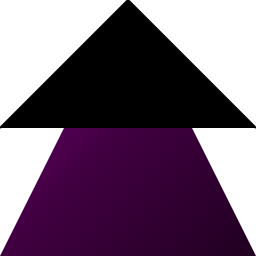

Prediction time for description 'gray wool coat with ...': 18.1072 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="50" y="50" width="156" height="156" fill="#808080"/><ellipse cx="128" cy="50" rx="40" ry="20" fill="#D3D3D3"/></svg>


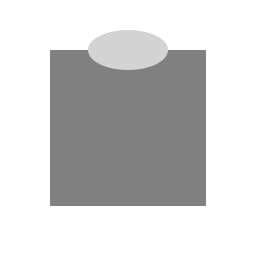

Prediction time for description 'a lighthouse overloo...': 22.2525 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="128" width="256" height="128" fill="blue"/><rect x="128" y="0" width="64" height="128" fill="gray"/><path d="M 128 80 L 160 160 L 96 160 Z" fill="white"/></svg>


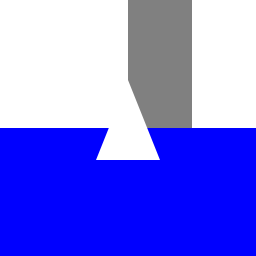

Prediction time for description 'burgundy corduroy pa...': 80.7797 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="20" y="50" width="216" height="180" fill="#800020" stroke="#800020" stroke-width="5"/><polygon points="20,50 25,45 30,50 25,55" fill="#800020" stroke="#800020" stroke-width="5"/><polygon points="240,50 235,45 230,50 235,55" fill="#800020" stroke="#800020" stroke-width="5"/><polygon points="20,180 25,175 30,180 25,185" fill="#800020" stroke="#800020" stroke-width="5"/><polygon points="240,180 235,175 230,180 235,185" fill="#800020" stroke="#800020" stroke-width="5"/><rect x="70" y="100" width="30" height="60" fill="#C0C0C0" stroke="#C0C0C0" stroke-width="2"/><rect x="160" y="100" width="30" height="60" fill="#C0C0C0" stroke="#C0C0C0" stroke-width="2"/><circle cx="128" cy="120" r="8" fill="#C0C0C0"/><circle cx="128" cy="160" r="8" fill="#C0C0C0"/></svg>


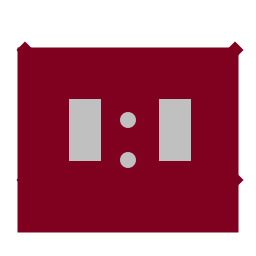

Prediction time for description 'orange corduroy over...': 50.9820 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="40" y="80" width="180" height="160" fill="orange" stroke="black" stroke-width="2"/><polyline points="40,80 40,100 196,100 196,80" fill="none" stroke="black" stroke-width="2"/><polyline points="40,120 40,140 196,140 196,120" fill="none" stroke="black" stroke-width="2"/><polyline points="40,160 40,180 196,180 196,160" fill="none" stroke="black" stroke-width="2"/><polyline points="40,200 40,220 196,220 196,200" fill="none" stroke="black" stroke-width="2"/><rect x="80" y="60" width="80" height="20" fill="orange"/></svg>


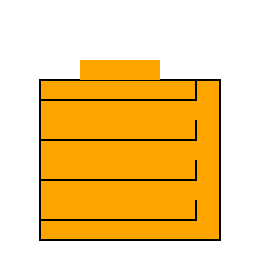

Prediction time for description 'a purple silk scarf ...': 29.4288 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><path d="M16 128 C32 64, 224 64, 232 128 C240 192, 32 192, 16 128 Z" fill="purple" stroke="purple" stroke-width="8"/><polyline points="232 128, 240 136, 232 144, 224 136, 216 144" fill="gold" stroke="gold" stroke-width="4"/></svg>


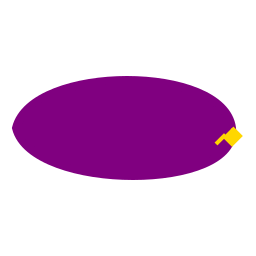

Prediction time for description 'a green lagoon under...': 25.2775 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="128" width="256" height="128" fill="green"/><g><ellipse cx="128" cy="64" rx="80" ry="32" fill="gray"/><circle cx="80" cy="32" r="12" fill="white"/><circle cx="176" cy="32" r="16" fill="white"/></g></svg>


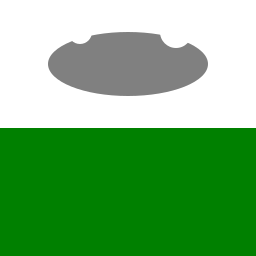

Prediction time for description 'crimson rectangles f...': 91.9708 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><circle cx="128" cy="128" r="80" fill="red"/><rect x="88" y="88" width="80" height="80" fill="blue"/></svg>


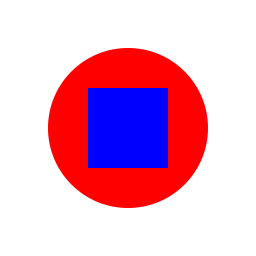

Prediction time for description 'purple pyramids spir...': 92.1654 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><circle cx="128" cy="128" r="80" fill="red"/><rect x="88" y="88" width="80" height="80" fill="blue"/></svg>


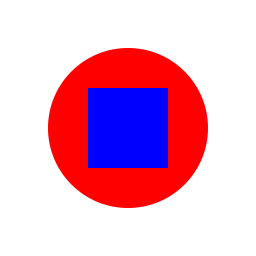

Prediction time for description 'magenta trapezoids l...': 30.6993 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="0" width="256" height="256" fill="silver" opacity="0.5"/><polygon points="20,20 150,20 230,150 20,150" fill="magenta"/><polygon points="50,50 180,50 230,180 50,180" fill="magenta"/><polygon points="80,80 200,80 230,200 80,200" fill="magenta"/></svg>


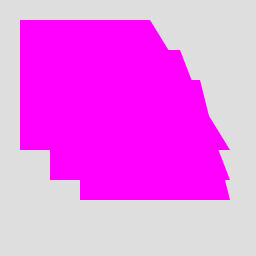

Prediction time for description 'a snowy plain...': 34.4052 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="0" width="256" height="256" fill="#f0f8ff"/><polyline points="0,256 256,256" stroke="white" stroke-width="2"/><polyline points="0,128 256,128" stroke="white" stroke-width="2"/><polyline points="0,64 256,64" stroke="white" stroke-width="2"/><circle cx="128" cy="128" r="10" fill="white"/><circle cx="200" cy="200" r="15" fill="white"/></svg>


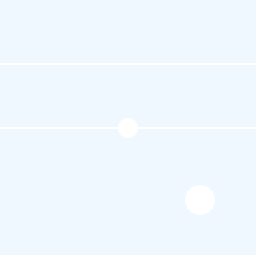

Prediction time for description 'black and white chec...': 57.5546 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="0" width="256" height="256" fill="white"/><g transform="translate(64,64)"><rect x="0" y="0" width="64" height="64" fill="black"/></g><g transform="translate(128,64)"><rect x="0" y="0" width="64" height="64" fill="white"/></g><g transform="translate(64,128)"><rect x="0" y="0" width="64" height="64" fill="black"/></g><g transform="translate(128,128)"><rect x="0" y="0" width="64" height="64" fill="white"/></g><g transform="translate(64,192)"><rect x="0" y="0" width="64" height="64" fill="white"/></g><g transform="translate(128,192)"><rect x="0" y="0" width="64" height="64" fill="black"/></g></svg>


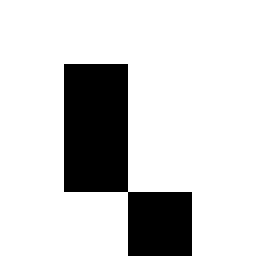

Prediction time for description 'a starlit night over...': 49.2142 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><rect x="0" y="0" width="256" height="128" fill="#E0FFFF"/><polygon points="128,256 144,224 160,256 176,224 208,251 224,220 238,253 256,221" fill="#D3D3D3"/><g transform="translate(128,128)"><circle cx="0" cy="-60" r="10" fill="#ADD8E6"/><circle cx="30" cy="-40" r="8" fill="#ADD8E6"/><circle cx="-30" cy="-50" r="12" fill="#ADD8E6"/><circle cx="-60" cy="-20" r="6" fill="#ADD8E6"/><circle cx="60" cy="-10" r="9" fill="#ADD8E6"/></g></svg>


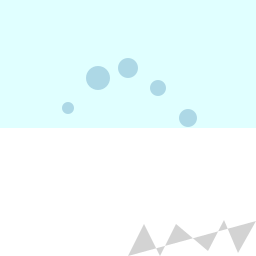

Prediction time for description 'khaki triangles and ...': 20.6900 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><polygon points="128,56 72,192 184,100" fill="khaki" opacity="0.8"/><path d="M 128,200 C 72,150 184,150 128,200" fill="azure" opacity="0.8"/></svg>


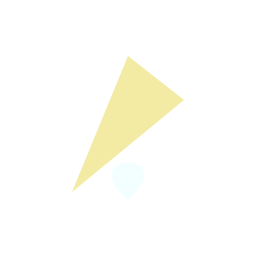

Prediction time for description 'a maroon dodecahedro...': 93.2951 seconds
<svg viewBox="0 0 256 256" width="256" height="256"><circle cx="128" cy="128" r="80" fill="red"/><rect x="88" y="88" width="80" height="80" fill="blue"/></svg>


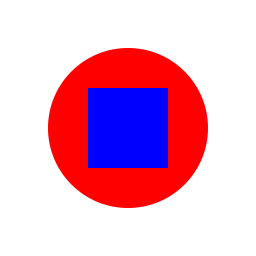

In [4]:
def generate():
    import polars as pl
    from IPython.display import SVG
    import time  # Import the time module
    
    logging.basicConfig(level=logging.ERROR, force=True)
    
    train = pl.read_csv('/kaggle/input/drawing-with-llms/train.csv')
    display(train.head())
    
    model = Model()
    svgs = []
    for desc in train.get_column('description'):
        start_time = time.time()  # Record start time
        svg = model.predict(desc)
        end_time = time.time()    # Record end time
        elapsed_time = end_time - start_time # Calculate elapsed time
        print(f"Prediction time for description '{desc[:20]}...': {elapsed_time:.4f} seconds") # Print time
        print(svg)
        try:
            display(SVG(svg))
        except Exception as e:
            print(e)
            continue

# Uncomment and run the line below to see some generated images
generate()